# Generador

Basada en el trabajo https://doi.org/10.1177/0003702819888949

Configuración del generador

In [1]:
import math
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
from random import random, sample
from joblib import Parallel, delayed
from scipy.stats import norm, uniform, poisson, bernoulli

# Posición más alta del vector que actúa como eje X
max_x = 1024

# Distribución de probabilidad a trozos que define la anchura de los spikes
# las constantes se escogen de forma que la probabilidad de un spike esté conformado por:
# - 5 puntos espectrales sea del 1%
# - 4 puntos espectrales sea del 4%
# - 3 puntos espectrales sea del 10%
# - 2 puntos espectrales sea del 15%
# - 1 punto espectral sea del 70%
def generador_anchura_picos():
    var = random()

    if var < .01:
        return (max_x / 1024) * 5 / 10
    elif var < .05:
        return (max_x / 1024) * 4 / 10
    elif var < .15:
        return (max_x / 1024) * 3 / 10
    elif var < .3:
        return (max_x / 1024) * 2 / 10
    else:
        return (max_x / 1024) * 1 / 10

config = {
    # Número de espectros a generar por ejecución
    'num_espectros_generados': 100,
    # Número de espectros en la visualización para control de calidad
    'tamano_muestra_visualizacion': 5,
    # Resolución del espectro (número de puntos espectrales)
    'tamano_vector': max_x,
    # Distribución para el número de picos Raman por espectro
    'dist_num_picos': uniform(loc=0, scale=8),
    # Distribución para la altura de los picos Raman en un espectro
    'dist_altura_picos': norm(loc=24, scale=7),
    # Distribución para la posición de los picos Raman dentro del espectro
    'dist_posicion_picos': uniform(loc=1, scale=max_x - 1),
    # Distribución para la anchura de los picos Raman en el espectro
    'dist_anchura_picos': norm(loc=15, scale=10),
    # Configuración del número de cambios de sentido de la derivada del baseline
    'dist_num_optimos_baseline': uniform(loc=0, scale=5),
    # Distribución de factor de altura del baseline (intensidad del baseline)
    'dist_altura_baseline': norm(loc=.7, scale=.15),
    # Distribución para el factor de comb lineal entre curva de muestra y baseline
    'dist_factor_combinacion': uniform(loc=0.2, scale=0.6),
    # Distribución del parámetro para generar ruido Poisson
    'dist_param_poisson': uniform(loc=5, scale=60),
    # Distribución para el número de spikes por espectro
    'dist_num_spikes': uniform(loc=0, scale=8),
    # Distribución para la posición de los spikes introducidos a los espectros
    'dist_posicion_spikes': uniform(loc=1, scale=max_x - 1),
    # Distribución para la altura de los spikes introducidos a los espectros
    'dist_altura_spikes': norm(loc=35, scale=30),
    # Distribución para el número de puntos que conforman los spikes introducidos a los espectros
    'dist_anchura_spikes': generador_anchura_picos,
    # Coeficiente empleado para calibrar la sensibilidad del labeling de spikes a partir de la curva de spikes generada
    'factor_deteccion_spikes': 0.01,
    # Distribución para el coeficiente de variación de parámetros, empleado
    # en la generación de espectros correlacionados
    'dist_ruido_porcentual_inyectado': norm(loc=0, scale=0.02),
    # Booleano que indica si los espectros generados han de guardarse en un archivo
    'guardar_espectros': True,
    # Booleano que indica si los espectros generados, al momento de guardarse,
    # deben ser adjuntados al final del archivo o sobreescribir el archivo
    'guardado_adjunto': False,
    # Booleano que indica que los espectros han de ser cargados y no generados
    'cargar_espectros': False,
    # Nombre del archivo con los espectros
    'nombre_archivo_espectros': 'resultados.ndjson',
    # Número de procesos concurrentes a emplear durante la generación
    'numero_procesos_concurrentes': 10
}

Funciones de generación de curvas espectroscópicas. Incluye perfiles normales, cauchy y voigt.

In [2]:
# El factor de anchura indica que aproximadamente a 1.4 veces su valor, a cada lado del centro,
# la distribución alcanza un 1% de su valor máximo
def generar_perfil_normal(vector_base, maximo, posicion, factor_anchura):
    argumento = (vector_base - posicion) / factor_anchura
    return maximo * np.exp(-4 * math.log(2) * (argumento ** 2))

# El factor de anchura indica que aproximadamente a 5 veces su valor, a cada lado del centro,
# la distribución alcanza un 1% de su valor máximo
def generar_perfil_cauchy(vector_base, maximo, posicion, factor_anchura):
    argumento = (vector_base - posicion) / factor_anchura
    return maximo / (1 + (argumento ** 2))

# El factor de anchura indica que aproximadamente a 4.5 a 4.9 veces su valor, a cada lado del centro,
# la distribución alcanza un 1% de su valor máximo
def generar_perfil_voigt(vector_base, maximo, posicion, factor_anchura):
    posicion_normal_cauchy = (posicion + len(vector_base) / 2) / 2
    perfil_normal = generar_perfil_normal(
        vector_base,
        maximo,
        posicion_normal_cauchy,
        factor_anchura
    )
    perfil_cauchy = generar_perfil_cauchy(
        vector_base,
        maximo,
        posicion_normal_cauchy,
        factor_anchura
    )

    perfil_voigt = np.convolve(perfil_normal, perfil_cauchy, 'same')

    maximo_perfil_voigt = np.max(perfil_voigt)

    if maximo_perfil_voigt == 0:
        return perfil_voigt

    return perfil_voigt * maximo / maximo_perfil_voigt

Funciones de generación de spikes

In [3]:
def generar_spikes(vector_base, lista_parametros):
    flag_spikes = np.full(len(vector_base), False)

    if len(lista_parametros) == 0:
        return np.zeros(len(vector_base)), flag_spikes

    perfiles_cauchy = [
        generar_perfil_cauchy(
            vector_base,
            altura,
            posicion,
            anchura
        ) for (altura, posicion, anchura) in lista_parametros
    ]

    for spike in perfiles_cauchy:
        flag_spikes = flag_spikes | (spike > config['factor_deteccion_spikes'] * np.max(spike))

    return np.sum(perfiles_cauchy, axis=0), flag_spikes

def generar_spikes_aleatorios(vector_base, dist_num_spikes, dist_posicion_spikes, dist_altura_spikes, dist_anchura_spikes):
    num_spikes = round(dist_num_spikes.rvs())

    lista_parametros = []

    for _ in range(num_spikes):
        altura = abs(dist_altura_spikes.rvs())
        posicion = round(dist_posicion_spikes.rvs())
        anchura = abs(dist_anchura_spikes())

        lista_parametros.append((altura, posicion, anchura))

    spikes, flag_spikes = generar_spikes(vector_base, lista_parametros)

    return spikes, lista_parametros, flag_spikes

Funciones de generación de picos Raman

In [4]:
def generar_picos_raman(vector_base, lista_parametros):
    if len(lista_parametros) == 0:
        return np.zeros(len(vector_base))

    perfiles_voigt = [
        generar_perfil_voigt(
            vector_base,
            altura,
            posicion,
            anchura
        ) for (altura, posicion, anchura) in lista_parametros
    ]

    return np.sum(perfiles_voigt, axis=0)

def generar_espectro_raman_aleatorio(vector_base, dist_num_picos, dist_alturas, dist_posiciones, dist_anchuras):
    num_picos = round(dist_num_picos.rvs())

    lista_parametros = [
        (abs(dist_alturas.rvs()), round(dist_posiciones.rvs()), abs(dist_anchuras.rvs())) for _ in range(num_picos)
    ]

    espectro_raman = generar_picos_raman(vector_base, lista_parametros)

    return espectro_raman, lista_parametros

Funciones de generación de baseline

In [5]:
umbral_diferencia_raices = 0.3

def generar_polinomio_baseline(vector_base, optimos, factor_lineal_especial, factor_altura, debe_voltearse, sumando_altura):
    coefs_derivada = []

    if len(optimos) > 0:
        coefs_derivada = np.polynomial.polynomial.polyfromroots(optimos)
    else:
        coefs_derivada = [factor_lineal_especial]

    if debe_voltearse:
        coefs_derivada = [-1 * coef for coef in coefs_derivada]

    coefs_pol = [coef / (n + 1) for n, coef in enumerate(coefs_derivada)]
    coefs_pol.insert(0, 0)

    lim_rango_inferior = -1
    lim_rango_superior = 1
    if len(optimos) > 0:
        lim_rango_inferior = np.min(optimos) - umbral_diferencia_raices
        lim_rango_superior = np.max(optimos) + umbral_diferencia_raices

    rango = np.linspace(lim_rango_inferior, lim_rango_superior, len(vector_base))
    pol = np.polyval(np.flip(coefs_pol), rango)

    pol_escalado = pol * factor_altura / np.max(np.abs(pol))

    polinomio_final = abs(np.min(pol_escalado)) + sumando_altura * factor_altura + pol_escalado

    return polinomio_final

def generar_polinomio_baseline_aleatorio(vector_base, dist_num_optimos, dist_altura_baseline, factor_altura):
    num_optimos = round(dist_num_optimos.rvs())
    optimos = []
    factor_lineal_especial = 0

    if num_optimos == 0:
        dist_coef_lineal = uniform(loc=-2, scale=4)
        factor_lineal_especial = dist_coef_lineal.rvs()

        while factor_lineal_especial == 0:
            factor_lineal_especial = dist_coef_lineal.rvs()

    dist_posicion_optimos = uniform(loc=-1, scale=2)

    for _ in range(num_optimos):
        nuevo_optimo = dist_posicion_optimos.rvs()

        if len(optimos) > 0:
            raices_cercanas = True
            contador = 0

            while raices_cercanas and contador < 100:
                contador = contador + 1
                diferencias = [optimo - nuevo_optimo for optimo in optimos]
                raices_cercanas = np.min(np.abs(diferencias)) < umbral_diferencia_raices

                if raices_cercanas:
                    nuevo_optimo = dist_posicion_optimos.rvs()

        optimos.append(nuevo_optimo)

    debe_voltearse = bernoulli(0.5).rvs() > 0.5
    sumando_altura = abs(dist_altura_baseline.rvs())

    parametros_polinomio = {
        'optimos': optimos,
        'factor_lineal_especial': factor_lineal_especial,
        'factor_altura': factor_altura,
        'sumando_altura': sumando_altura,
        'debe_voltearse': debe_voltearse
    }

    return generar_polinomio_baseline(
        vector_base,
        optimos,
        factor_lineal_especial,
        factor_altura,
        debe_voltearse,
        sumando_altura
    ), parametros_polinomio

Funciones de generación de espectros completos

In [6]:
def paso_1_aleatorio(vector_base):
    espectro_muestra, lista_parametros_muestra = generar_espectro_raman_aleatorio(
        vector_base,
        config['dist_num_picos'],
        config['dist_altura_picos'],
        config['dist_posicion_picos'],
        config['dist_anchura_picos']
    )

    espectro_background, lista_parametros_background = generar_espectro_raman_aleatorio(
        vector_base,
        config['dist_num_picos'],
        config['dist_altura_picos'],
        config['dist_posicion_picos'],
        config['dist_anchura_picos']
    )

    return espectro_muestra, espectro_background, lista_parametros_muestra, lista_parametros_background

def paso_2_aleatorio(vector_base, factor_altura_muestra, factor_altura_background):
    baseline_muestra, parametros_baseline_muestra = generar_polinomio_baseline_aleatorio(
        vector_base,
        config['dist_num_optimos_baseline'],
        config['dist_altura_baseline'],
        factor_altura_muestra
    )

    baseline_background, parametros_baseline_background = generar_polinomio_baseline_aleatorio(
        vector_base,
        config['dist_num_optimos_baseline'],
        config['dist_altura_baseline'],
        factor_altura_background
    )

    return baseline_muestra, baseline_background, parametros_baseline_muestra, parametros_baseline_background

def paso_3_aleatorio(y_muestra, y_background, dist_factor_combinacion):
    factor_comb_lineal = dist_factor_combinacion.rvs()

    espectro_combinado = factor_comb_lineal * y_muestra + (1 - factor_comb_lineal) * y_background

    return espectro_combinado, factor_comb_lineal

def paso_4_aleatorio(espectro_combinado, espectro_background, dist_param_poisson):
    k_combinado_poisson = dist_param_poisson.rvs()
    k_background_poisson = dist_param_poisson.rvs()

    espectro_ruido_combinado = poisson.rvs(k_combinado_poisson * espectro_combinado)
    espectro_ruido_background = poisson.rvs(k_background_poisson * espectro_background)

    maximo_espectro_ruido_combinado = np.max(espectro_ruido_combinado)

    if maximo_espectro_ruido_combinado > 0:
        espectro_ruido_combinado = espectro_ruido_combinado * np.max(espectro_combinado) / maximo_espectro_ruido_combinado

    maximo_espectro_ruido_background = np.max(espectro_ruido_background)

    if maximo_espectro_ruido_background > 0:
        espectro_ruido_background = espectro_ruido_background * np.max(espectro_background) / maximo_espectro_ruido_background

    return espectro_ruido_combinado, espectro_ruido_background, k_combinado_poisson, k_background_poisson

def paso_5_aleatorio(vector_base, dist_num_spikes, dist_posicion_spikes, dist_altura_spikes, dist_anchura_spikes):
    spikes_muestra, parametros_spike_muestra, flag_spikes_muestra = generar_spikes_aleatorios(
        vector_base,
        dist_num_spikes,
        dist_posicion_spikes,
        dist_altura_spikes,
        dist_anchura_spikes
    )

    spikes_background, parametros_spike_background, flag_spikes_background = generar_spikes_aleatorios(
        vector_base,
        dist_num_spikes,
        dist_posicion_spikes,
        dist_altura_spikes,
        dist_anchura_spikes
    )

    return spikes_muestra, parametros_spike_muestra, flag_spikes_muestra, spikes_background, parametros_spike_background, flag_spikes_background

def anadir_ruido_poisson_espectro(espectro, **poisson_params):
    maximo_espectro = np.max(espectro)
    k_poisson = None
    dist_param_poisson = None

    for key, value in poisson_params.items():
        if key == 'k_poisson':
            k_poisson = value
        elif key == 'dist_param_poisson':
            dist_param_poisson = value

    if dist_param_poisson != None:
        k_poisson = dist_param_poisson.rvs()

    espectro_ruido = poisson.rvs(k_poisson * espectro)
    maximo_espectro_ruido = np.max(espectro_ruido)
    if maximo_espectro_ruido > 0:
        espectro_ruido = espectro_ruido * maximo_espectro / maximo_espectro_ruido

    return espectro_ruido

def generar_espectro_ruido_aleatorio(config):
    datos = {}

    vector_base = np.linspace(1, config['tamano_vector'], config['tamano_vector'])

    datos['vector_base'] = vector_base

    y_muestra = np.zeros(len(vector_base))
    y_background = np.zeros(len(vector_base))

    espectro_muestra, espectro_background, lista_parametros_muestra, lista_parametros_background = paso_1_aleatorio(vector_base)

    datos['espectro_base_muestra'] = espectro_muestra
    datos['espectro_base_background'] = espectro_background
    datos['parametros_espectro_base_muestra'] = lista_parametros_muestra
    datos['parametros_espectro_base_background'] = lista_parametros_background
    y_muestra = y_muestra + espectro_muestra
    y_background = y_background + espectro_background

    baseline_muestra, baseline_background, parametros_baseline_muestra, parametros_baseline_background = paso_2_aleatorio(
        vector_base,
        np.max(espectro_muestra),
        np.max(espectro_background)
    )

    datos['baseline_muestra'] = baseline_muestra
    datos['baseline_background'] = baseline_background
    datos['parametros_baseline_muestra'] = parametros_baseline_muestra
    datos['parametros_baseline_background'] = parametros_baseline_background

    y_muestra = y_muestra + baseline_muestra
    y_background = y_background + baseline_background

    datos['muestra_con_baseline'] = y_muestra
    datos['background_con_baseline'] = y_background

    espectro_combinado, factor_comb_lineal = paso_3_aleatorio(y_muestra, y_background, config['dist_factor_combinacion'])

    datos['factor_comb_lineal'] = factor_comb_lineal
    datos['muestra_combinado_base'] = espectro_combinado

    espectro_ruido_combinado, espectro_ruido_background, k_combinado_poisson, k_background_poisson = paso_4_aleatorio(
        espectro_combinado,
        y_background,
        config['dist_param_poisson']
    )

    datos['k_combinado_poisson'] = k_combinado_poisson
    datos['k_background_poisson'] = k_background_poisson
    datos['espectro_ruido_combinado'] = espectro_ruido_combinado
    datos['espectro_ruido_background'] = espectro_ruido_background

    spikes_muestra, parametros_spike_muestra, flag_spikes_muestra, spikes_background, parametros_spike_background, flag_spikes_background = paso_5_aleatorio(
        vector_base,
        config['dist_num_spikes'],
        config['dist_posicion_spikes'],
        config['dist_altura_spikes'],
        config['dist_anchura_spikes']
    )

    y_muestra = espectro_ruido_combinado + spikes_muestra
    y_background = espectro_ruido_background + spikes_background

    datos['spikes_muestra'] = spikes_muestra
    datos['spikes_background'] = spikes_background
    datos['parametros_spike_muestra'] = parametros_spike_muestra
    datos['parametros_spike_background'] = parametros_spike_background
    datos['flag_spikes_muestra'] = flag_spikes_muestra
    datos['flag_spikes_background'] = flag_spikes_background

    muestra_base_con_spikes = espectro_muestra + spikes_muestra

    muestra_base_con_spikes_ruido = anadir_ruido_poisson_espectro(muestra_base_con_spikes, k_poisson=k_combinado_poisson)

    datos['muestra_base_con_spikes'] = muestra_base_con_spikes_ruido

    datos['y_muestra'] = y_muestra
    datos['y_background'] = y_background

    return datos

Funciones de generación de espectros correlacionados.

Estas funciones reciben un espectro y generan otro añadiendo pequeñas perturbaciones aleatorias a sus parámetros de generación.

In [7]:
def inyectar_ruido_parametro(parametro, dist_ruido):
    return parametro * (1 + dist_ruido.rvs())

def generar_espectro_correlacionado(config, datos_espectro_base):
    datos = {}
    copia_espectro = copy.deepcopy(datos_espectro_base)
    vector_base = copia_espectro['vector_base']

    datos['vector_base'] = vector_base

    y_muestra = np.zeros(len(vector_base))
    y_background = np.zeros(len(vector_base))

    dist_ruido_inyectado = config['dist_ruido_porcentual_inyectado']

    parametros_espectro_base_muestra = copia_espectro['parametros_espectro_base_muestra']
    parametros_espectro_base_background = copia_espectro['parametros_espectro_base_background']

    parametros_espectro_base_muestra_ruido = [
        (
            abs(inyectar_ruido_parametro(altura, dist_ruido_inyectado)),
            round(inyectar_ruido_parametro(posicion, dist_ruido_inyectado)),
            abs(inyectar_ruido_parametro(anchura, dist_ruido_inyectado))
        ) for (altura, posicion, anchura) in parametros_espectro_base_muestra
    ]

    parametros_espectro_base_background = [
        (
            abs(inyectar_ruido_parametro(altura, dist_ruido_inyectado)),
            round(inyectar_ruido_parametro(posicion, dist_ruido_inyectado)),
            abs(inyectar_ruido_parametro(anchura, dist_ruido_inyectado))
        ) for (altura, posicion, anchura) in parametros_espectro_base_background
    ]

    espectro_muestra = generar_picos_raman(vector_base, parametros_espectro_base_muestra_ruido)
    espectro_background = generar_picos_raman(vector_base, parametros_espectro_base_background)

    datos['espectro_base_muestra'] = espectro_muestra
    datos['espectro_base_background'] = espectro_background
    datos['parametros_espectro_base_muestra'] = parametros_espectro_base_muestra_ruido
    datos['parametros_espectro_base_background'] = parametros_espectro_base_background
    y_muestra = y_muestra + espectro_muestra
    y_background = y_background + espectro_background
    datos['muestra_con_baseline'] = y_muestra
    datos['background_con_baseline'] = y_background

    nuevos_optimos_baseline_muestra = [
        inyectar_ruido_parametro(optimo, dist_ruido_inyectado) for optimo in copia_espectro['parametros_baseline_muestra']['optimos']
    ]
    nuevo_factor_altura_baseline_muestra = abs(inyectar_ruido_parametro(copia_espectro['parametros_baseline_muestra']['factor_altura'], dist_ruido_inyectado))
    nuevo_sumando_altura_muestra = abs(inyectar_ruido_parametro(copia_espectro['parametros_baseline_muestra']['sumando_altura'], dist_ruido_inyectado))

    nuevos_optimos_baseline_background = [
        inyectar_ruido_parametro(optimo, dist_ruido_inyectado) for optimo in copia_espectro['parametros_baseline_background']['optimos']
    ]
    nuevo_factor_altura_baseline_background = inyectar_ruido_parametro(copia_espectro['parametros_baseline_background']['factor_altura'], dist_ruido_inyectado)
    nuevo_sumando_altura_background = inyectar_ruido_parametro(copia_espectro['parametros_baseline_background']['sumando_altura'], dist_ruido_inyectado)

    baseline_muestra = generar_polinomio_baseline(
        vector_base,
        nuevos_optimos_baseline_muestra,
        copia_espectro['parametros_baseline_muestra']['factor_lineal_especial'],
        nuevo_factor_altura_baseline_muestra,
        copia_espectro['parametros_baseline_muestra']['debe_voltearse'],
        nuevo_sumando_altura_muestra
    )

    parametros_baseline_muestra = {
        'optimos': nuevos_optimos_baseline_muestra,
        'factor_lineal_especial': copia_espectro['parametros_baseline_muestra']['factor_lineal_especial'],
        'factor_altura': nuevo_factor_altura_baseline_muestra,
        'sumando_altura': nuevo_sumando_altura_muestra,
        'debe_voltearse': copia_espectro['parametros_baseline_muestra']['debe_voltearse']
    }

    baseline_background = generar_polinomio_baseline(
        vector_base,
        nuevos_optimos_baseline_background,
        copia_espectro['parametros_baseline_background']['factor_lineal_especial'],
        nuevo_factor_altura_baseline_background,
        copia_espectro['parametros_baseline_background']['debe_voltearse'],
        nuevo_sumando_altura_background
    )

    parametros_baseline_background = {
        'optimos': nuevos_optimos_baseline_background,
        'factor_lineal_especial': copia_espectro['parametros_baseline_background']['factor_lineal_especial'],
        'factor_altura': nuevo_factor_altura_baseline_background,
        'sumando_altura': nuevo_sumando_altura_background,
        'debe_voltearse': copia_espectro['parametros_baseline_background']['debe_voltearse']
    }

    datos['baseline_muestra'] = baseline_muestra
    datos['baseline_background'] = baseline_background
    datos['parametros_baseline_muestra'] = parametros_baseline_muestra
    datos['parametros_baseline_background'] = parametros_baseline_background

    y_muestra = y_muestra + baseline_muestra
    y_background = y_background + baseline_background

    factor_comb_lineal = copia_espectro['factor_comb_lineal']

    espectro_combinado = factor_comb_lineal * y_muestra + (1 - factor_comb_lineal) * y_background

    datos['factor_comb_lineal'] = factor_comb_lineal
    datos['muestra_combinado_base'] = espectro_combinado

    k_combinado_poisson = copia_espectro['k_combinado_poisson']
    k_background_poisson = copia_espectro['k_background_poisson']

    espectro_ruido_combinado = poisson.rvs(k_combinado_poisson * espectro_combinado)
    espectro_ruido_background = poisson.rvs(k_background_poisson * y_background)

    maximo_espectro_ruido_combinado = np.max(espectro_ruido_combinado)

    if maximo_espectro_ruido_combinado > 0:
        espectro_ruido_combinado = espectro_ruido_combinado * np.max(espectro_combinado) / maximo_espectro_ruido_combinado

    maximo_espectro_ruido_background = np.max(espectro_ruido_background)

    if maximo_espectro_ruido_background > 0:
        espectro_ruido_background = espectro_ruido_background * np.max(y_background) / maximo_espectro_ruido_background

    datos['k_combinado_poisson'] = k_combinado_poisson
    datos['k_background_poisson'] = k_background_poisson
    datos['espectro_ruido_combinado'] = espectro_ruido_combinado
    datos['espectro_ruido_background'] = espectro_ruido_background

    spikes_muestra, parametros_spike_muestra, flag_spikes_muestra, spikes_background, parametros_spike_background, flag_spikes_background = paso_5_aleatorio(
        vector_base,
        config['dist_num_spikes'],
        config['dist_posicion_spikes'],
        config['dist_altura_spikes'],
        config['dist_anchura_spikes']
    )

    y_muestra = espectro_ruido_combinado + spikes_muestra
    y_background = espectro_ruido_background + spikes_background

    datos['spikes_muestra'] = spikes_muestra
    datos['spikes_background'] = spikes_background
    datos['parametros_spike_muestra'] = parametros_spike_muestra
    datos['parametros_spike_background'] = parametros_spike_background
    datos['flag_spikes_muestra'] = flag_spikes_muestra
    datos['flag_spikes_background'] = flag_spikes_background

    muestra_base_con_spikes = espectro_muestra + spikes_muestra

    muestra_base_con_spikes_ruido = anadir_ruido_poisson_espectro(muestra_base_con_spikes, k_poisson=k_combinado_poisson)

    datos['muestra_base_con_spikes'] = muestra_base_con_spikes_ruido

    datos['y_muestra'] = y_muestra
    datos['y_background'] = y_background

    return datos

# Ejecución del generador de espectros

Funciones de serialización/deserialización de los diccionarios empleados para guardar/cargar espectros.

In [8]:
def serializar_espectro(espectro):
    copia = copy.deepcopy(espectro)
    copia['vector_base'] = copia['vector_base'].tolist()
    copia['espectro_base_muestra'] = copia['espectro_base_muestra'].tolist()
    copia['espectro_base_background'] = copia['espectro_base_background'].tolist()
    copia['baseline_muestra'] = copia['baseline_muestra'].tolist()
    copia['baseline_background'] = copia['baseline_background'].tolist()
    copia['muestra_con_baseline'] = copia['muestra_con_baseline'].tolist()
    copia['background_con_baseline'] = copia['background_con_baseline'].tolist()
    copia['muestra_combinado_base'] = copia['muestra_combinado_base'].tolist()
    copia['espectro_ruido_combinado'] = copia['espectro_ruido_combinado'].tolist()
    copia['espectro_ruido_background'] = copia['espectro_ruido_background'].tolist()
    copia['spikes_muestra'] = copia['spikes_muestra'].tolist()
    copia['spikes_background'] = copia['spikes_background'].tolist()
    copia['flag_spikes_muestra'] = copia['flag_spikes_muestra'].tolist()
    copia['flag_spikes_background'] = copia['flag_spikes_background'].tolist()
    copia['muestra_base_con_spikes'] = copia['muestra_base_con_spikes'].tolist()
    copia['y_muestra'] = copia['y_muestra'].tolist()
    copia['y_background'] = copia['y_background'].tolist()

    return copia

def deserializar_espectro(espectro):
    espectro['vector_base'] = np.array(espectro['vector_base'])
    espectro['espectro_base_muestra'] = np.array(espectro['espectro_base_muestra'])
    espectro['espectro_base_background'] = np.array(espectro['espectro_base_background'])
    espectro['baseline_muestra'] = np.array(espectro['baseline_muestra'])
    espectro['baseline_background'] = np.array(espectro['baseline_background'])
    espectro['muestra_con_baseline'] = np.array(espectro['muestra_con_baseline'])
    espectro['background_con_baseline'] = np.array(espectro['background_con_baseline'])
    espectro['muestra_combinado_base'] = np.array(espectro['muestra_combinado_base'])
    espectro['espectro_ruido_combinado'] = np.array(espectro['espectro_ruido_combinado'])
    espectro['espectro_ruido_background'] = np.array(espectro['espectro_ruido_background'])
    espectro['spikes_muestra'] = np.array(espectro['spikes_muestra'])
    espectro['spikes_background'] = np.array(espectro['spikes_background'])
    espectro['flag_spikes_muestra'] = np.array(espectro['flag_spikes_muestra'])
    espectro['flag_spikes_background'] = np.array(espectro['flag_spikes_background'])
    espectro['muestra_base_con_spikes'] = np.array(espectro['muestra_base_con_spikes'])
    espectro['y_muestra'] = np.array(espectro['y_muestra'])
    espectro['y_background'] = np.array(espectro['y_background'])

    return espectro

Funciones para carga o generación de archivos

In [9]:
espectros = []

def generar_espectros():
    return Parallel(n_jobs=config['numero_procesos_concurrentes'])(delayed(generar_espectro_ruido_aleatorio)(config) for _ in range(config['num_espectros_generados']))

def cargar_espectros():
    with open(config['nombre_archivo_espectros'], 'r') as fp:
        data = []
        for line in fp:
            data.append(deserializar_espectro(json.loads(line)))
        fp.close()
        return data

Ejecución de la generación, carga o guardado de espectros. De acuerdo a los parámetros.

In [10]:

if not config['cargar_espectros']:
    espectros = generar_espectros()
else:
    espectros = cargar_espectros()

if not config['cargar_espectros'] and config['guardar_espectros']:
    with open(config['nombre_archivo_espectros'], 'a' if config['guardado_adjunto'] else 'w') as fp:
        [fp.write(json.dumps(serializar_espectro(espectro), indent=None, separators=(',', ':')) + '\n')for espectro in espectros]
        fp.close()

# Visualización de los espectros generados

A forma de control de calidad

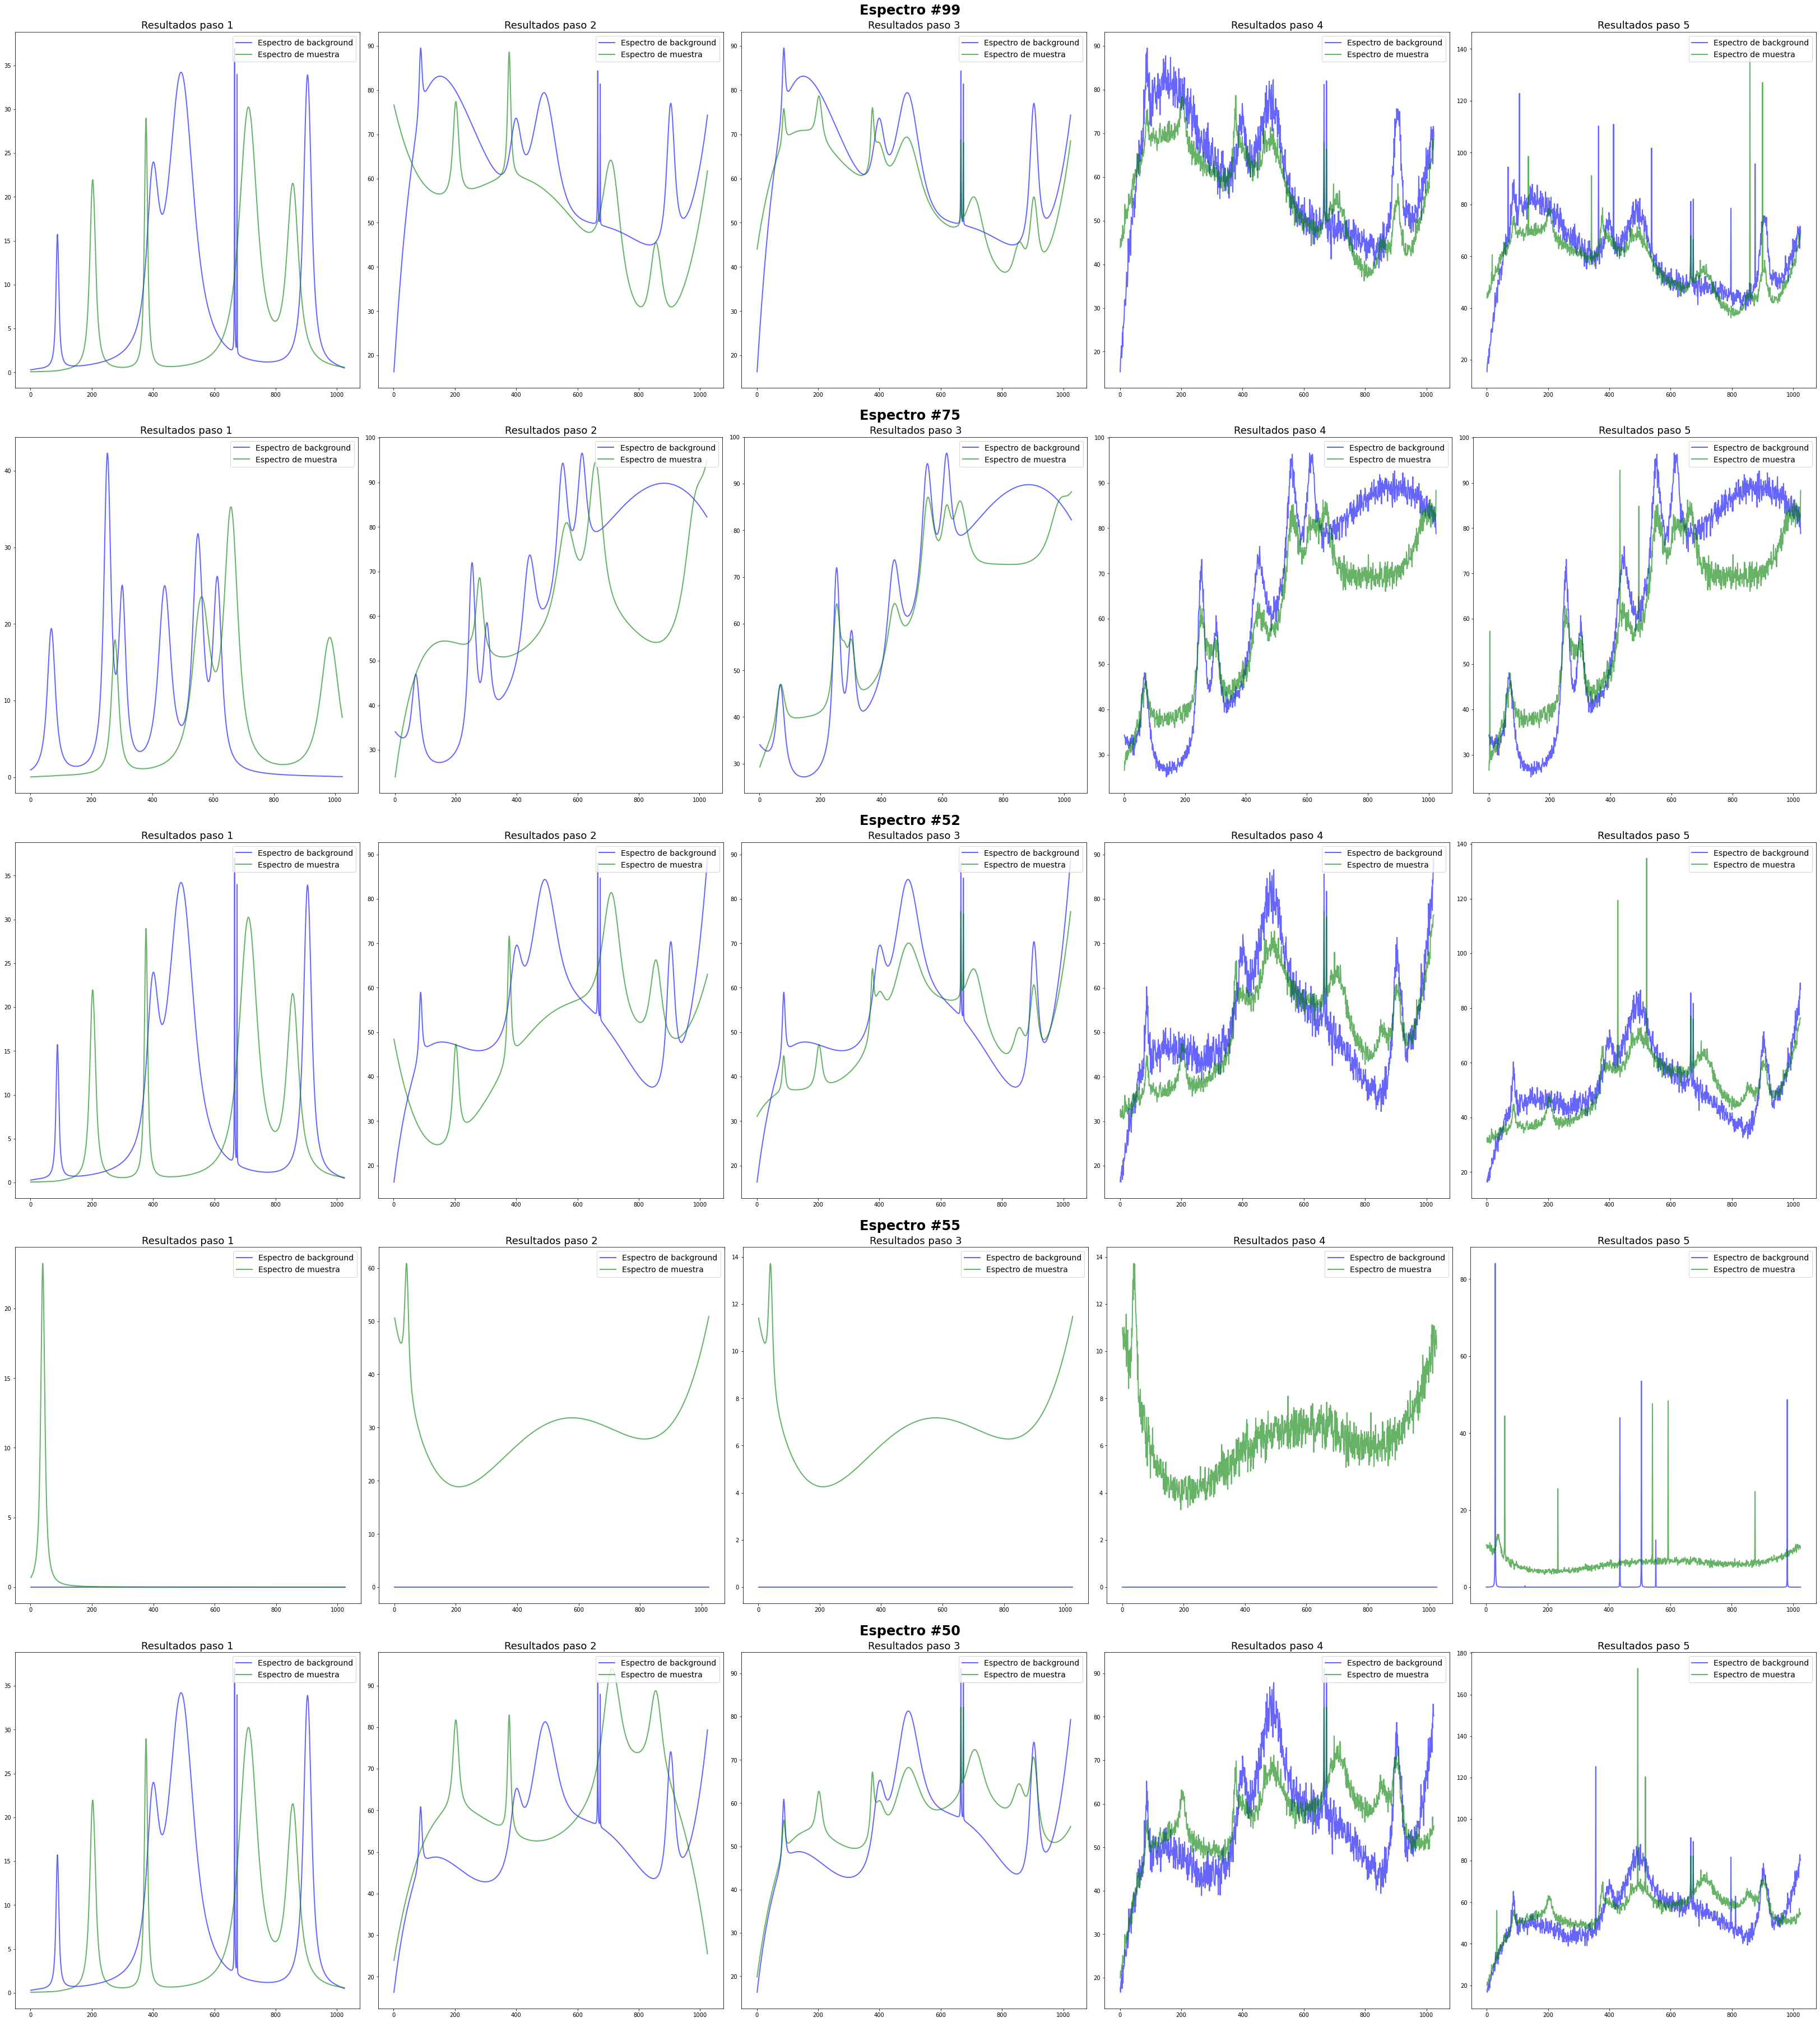

In [11]:
fig = plt.figure(figsize=[45, 10 * config['tamano_muestra_visualizacion']], constrained_layout=True)

subfigs = fig.subfigures(nrows=config['tamano_muestra_visualizacion'], ncols=1)

muestra = sample(list(enumerate(espectros)), config['tamano_muestra_visualizacion'])

def plot_espectro(x, y_muestra, y_background, ax, titulo):
    ax.plot(x, y_background, 'b-', lw=2, alpha=0.6, label="Espectro de background")
    ax.plot(x, y_muestra, 'g-', lw=2, alpha=0.6, label="Espectro de muestra")

    ax.set_title(titulo, fontsize=18)
    ax.legend(loc="upper right", fontsize=14)

for row, subfig in enumerate(subfigs):
    (index, espectro) = muestra[row]

    subfig.suptitle(f'Espectro #{index}', fontsize=24, fontweight='bold')

    (paso_1, paso_2, paso_3, paso_4, paso_5) = subfig.subplots(nrows=1, ncols=5)

    plot_espectro(
        espectro['vector_base'],
        espectro['espectro_base_muestra'],
        espectro['espectro_base_background'],
        paso_1,
        "Resultados paso 1"
    )

    plot_espectro(
        espectro['vector_base'],
        espectro['muestra_con_baseline'],
        espectro['background_con_baseline'],
        paso_2,
        "Resultados paso 2"
    )

    plot_espectro(
        espectro['vector_base'],
        espectro['muestra_combinado_base'],
        espectro['background_con_baseline'],
        paso_3,
        "Resultados paso 3"
    )

    plot_espectro(
        espectro['vector_base'],
        espectro['espectro_ruido_combinado'],
        espectro['espectro_ruido_background'],
        paso_4,
        "Resultados paso 4"
    )

    plot_espectro(
        espectro['vector_base'],
        espectro['y_muestra'],
        espectro['y_background'],
        paso_5,
        "Resultados paso 5"
    )